In [1]:
import networkx as nx
import requests
import time
from bs4 import BeautifulSoup 
import re
import matplotlib.pyplot as plt

import pickle


In [2]:
BASE_URL = 'https://www.walletexplorer.com/'

In [3]:
class RequestThrottler:
    def __init__(self, requests_per_minute):
        self.requests_per_minute = requests_per_minute
        self.interval = 60.0 / requests_per_minute
        self.last_request_time = 0
        
    def get(self, url, **kwargs):
        current_time = time.time()
        elapsed = current_time - self.last_request_time
        if elapsed < self.interval:
            time.sleep(self.interval - elapsed)
        response = requests.get(url, **kwargs)
        self.last_request_time = time.time()
        
        if response.status_code == 429:
            print("Too many request detected, doubling throttle time...")
            self.requests_per_minute = self.requests_per_minute / 2
            self.interval = 60.0 / self.requests_per_minute

            return self.get(url, **kwargs)
        return response

In [4]:
throttler = RequestThrottler(50)

In [7]:
Tx.load_cache('data/txcache.pkl')

In [6]:
class Tx: 
    cache = {}
    def save_cache(path):
        with open(path, 'wb') as file:
            pickle.dump(Tx.cache, file)

    def load_cache(path):
        with open(path, 'rb') as file:
            loaded_dict = pickle.load(file)
            Tx.cache = loaded_dict
    
    def __init__(self, txID):
        self.id = txID
        self.loaded = False

    def __set_stats(self, stats):
        Tx.cache[self.id] = stats
        self.addr_in  = stats[0]
        self.addr_out = stats[1]
        self.loaded = True

    def __parse_rows(self, rows):
        assert len(rows) > 0, "Error: somthing strange happend, trying to parse 0 rows"
        addr_list = []
        for tr in rows:
            tds = list(tr.children)
            if len(tds) != 3 and len(tds) != 4:
                print("cannot correctly identify row elements (maby is a coinbase tx?) skipping...", tds)
                continue
    
            addr_link = tds[0].find('a', href=lambda href: href and href.startswith('/address/'))
            # assert addr_link is not None, f"Error: cannot find correctly addr_link of cell: {self.id}"
            addr = None
            if addr_link:
                addr = addr_link['href'][9:]
    
            amount_idx = 1
            wallet = None
            if len(tds) == 4:
                amount_idx = 2
                wallet = tds[1].find('a', href=lambda href: href and href.startswith('/wallet/'))
                if wallet:
                    wallet = wallet['href'][8:]
            
            if not wallet and addr_link:
                url = f"{BASE_URL}/address/{addr}"
                response = throttler.get(url)
                soup = BeautifulSoup(response.content, 'html.parser')
                
                a = soup.find('a', href=lambda href: href and href.startswith('/wallet/'))
                assert a is not None, f"Error: site is changend no wallet link into address page, txID: {self.id}, url: {url}, content:{soup}"
                wallet = a['href'][8:]
                assert wallet, "Error: err not expected wallet is None"

            if not wallet:
                wallet = "Uknw" #Non standard transaction (unknown addr) 
            
            amount_text = tds[amount_idx].get_text();
            numbers = re.findall(r'-?\d+\.?\d*', amount_text)
            numbers = [float(n) for n in numbers]
            assert len(numbers) == 1, "Error: 0 or more then 1 values found extracting BTC amount"
            amount = numbers[0]
    
            linked_tx_a = tds[amount_idx + 1].find_all('a', href=lambda href: href and href.startswith('/txid/'))
            assert len(linked_tx_a) <= 1, "Error: more then 1 linked tx."
            
            linked_tx = None
            if len(linked_tx_a) == 1:
                linked_tx = Tx(linked_tx_a[0]['href'][6:])

            if not addr:
                addr = f"Uknw-{wallet}" #Non standard transaction (unknown addr)
                    
            addr_list.append((addr, wallet, amount, self, linked_tx))
        
        return addr_list
         
    def __load_stats(self):
        if self.loaded:
            return;

        if self.id in Tx.cache:
            self.__set_stats(Tx.cache[self.id])
            return
        
        response = throttler.get(f"{BASE_URL}/txid/{self.id}")
        soup = BeautifulSoup(response.content, 'html.parser')

        tx_table = soup.find('table', {"class": 'tx'})
        assert tx_table, f"Error: cannot find table txID: {self.id}"
        tx_tables = tx_table.find_all('table')
        assert len(tx_tables) == 2 , "Error: cannot find tables inside table"
       
        i_rows = tx_tables[0].find_all("tr")
        o_rows = tx_tables[1].find_all("tr")
        self.__set_stats((self.__parse_rows(i_rows), self.__parse_rows(o_rows)))
            
    def outputs(self):
        self.__load_stats()
        return self.addr_out

    def inputs(self):
        self.__load_stats()
        return self.addr_in


# initialTx = Tx('8ebe1df6ebf008f7ec42ccd022478c9afaec3ca0444322243b745aa2e317c272')
# print(initialTx.outputs())
# print(initialTx.inputs())

In [269]:
Tx.save_cache('data/txcache.pkl')

In [8]:
def hierarchy_pos_no_recur(
    G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5
):
    """If there is a cycle that is reachable from root, then result will not be a hierarchy.

    G: the graph
    root: the root node of current branch
    width: horizontal space allocated for this branch - avoids overlap with other branches
    vert_gap: gap between levels of hierarchy
    vert_loc: vertical location of root
    xcenter: horizontal location of root
    """

    def h_recur(
        G,
        root,
        width=1.0,
        vert_gap=0.2,
        vert_loc=0,
        xcenter=0.5,
        pos=None,
        parent=None,
        parsed=[],
    ):
        if root not in parsed:
            parsed.append(root)
            if pos == None:
                pos = {root: (xcenter, vert_loc)}
            else:
                pos[root] = (xcenter, vert_loc)
            neighbors = list(G.neighbors(root))
            if parent != None and parent in neighbors:
                neighbors.remove(parent)
            if len(neighbors) > 0:
                dx = width / len(neighbors)
                nextx = xcenter - width / 2 - dx / 2
                for neighbor in neighbors:
                    nextx += dx
                    pos = h_recur(
                        G,
                        neighbor,
                        width=dx,
                        vert_gap=vert_gap,
                        vert_loc=vert_loc - vert_gap,
                        xcenter=nextx,
                        pos=pos,
                        parent=root,
                        parsed=parsed,
                    )
        return pos

    return h_recur(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5)

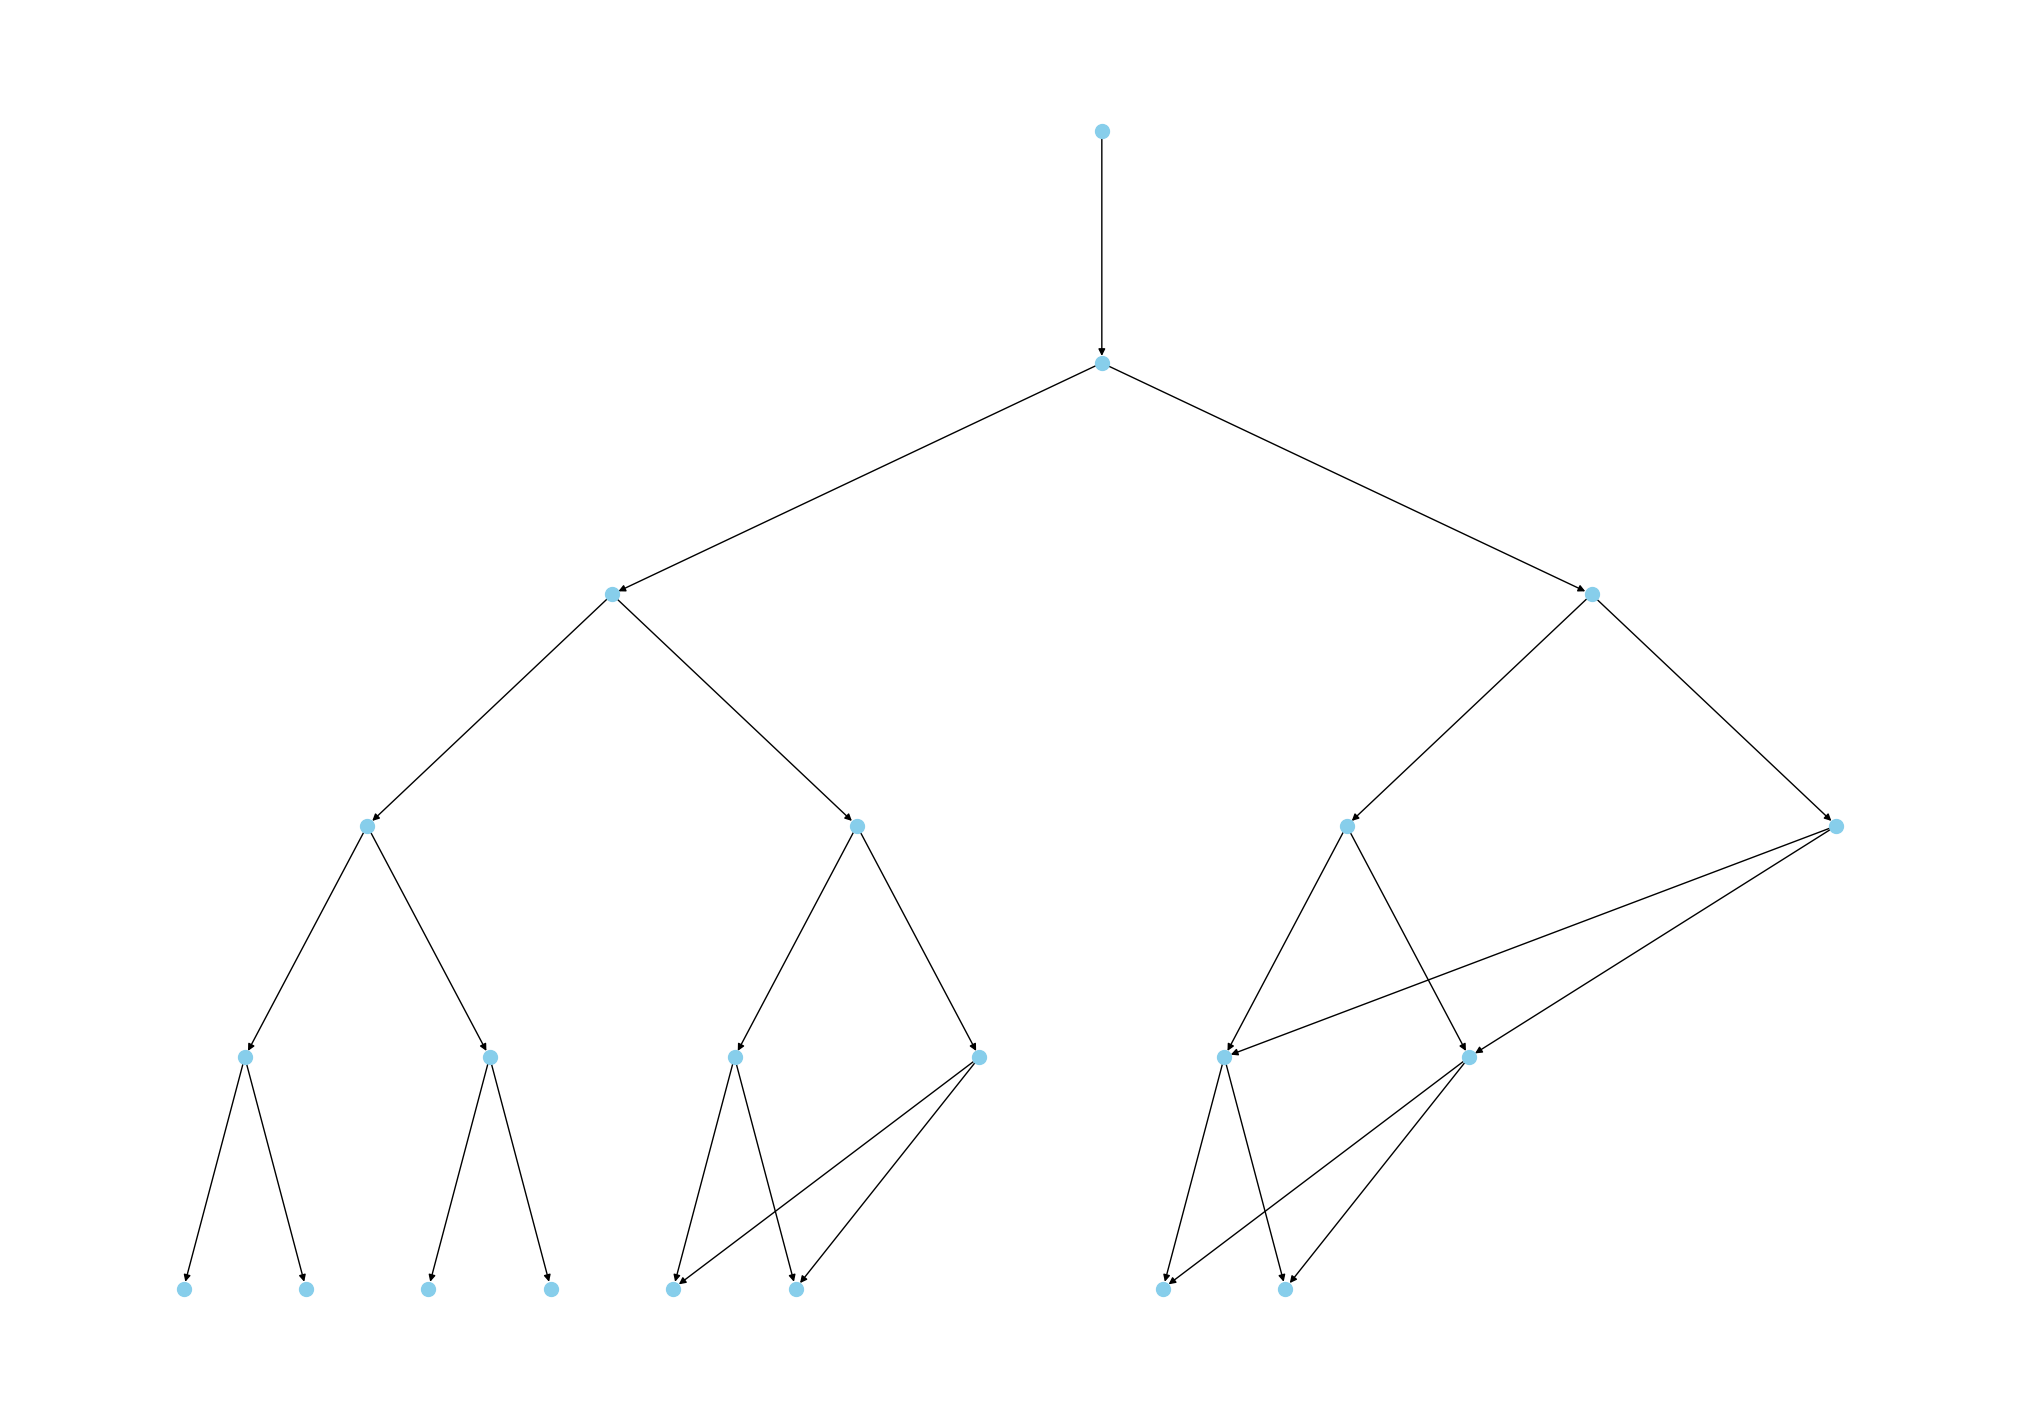

In [10]:
g = nx.DiGraph()

initial_addr = ("coinbase", "coinbase", 0, None, Tx('c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6'))

def add_addr_outputs(g, addr, depth=1):
    # print("adding", addr)
    if depth == 0:
        return
        
    addr_name = addr[0]

    g.add_node(addr[0], wallet=addr[1])
    
    out_tx = addr[4]
    out_addr = out_tx.outputs()
    for a in out_addr:
        g.add_node(a[0], wallet=a[1])
        g.add_edge(addr_name, a[0])
        if a[4]:
            add_addr_outputs(g, a, depth-1)

add_addr_outputs(g, initial_addr, 5)

# def format_node_label(node):
#     return f"{node[:4]}..."  

# node_labels = {node: format_node_label(node) for node in g.nodes()}
# edge_labels = {(u, v): g[u][v]['label'] for u, v in g.edges()}

# pos = nx.spring_layout(g, seed=1, scale=4000)
# nx.draw(g, pos, with_labels=False, node_color='lightblue', node_size=200)

# nx.draw_networkx_labels(g, pos, labels=node_labels, font_size=8, font_color='red')
# nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='green')

# nx.draw_networkx(g)

# nx.draw_shell(g, with_labels=True, font_weight='bold')
def topo_pos(G):
    """Display in topological order, with simple offsetting for legibility"""
    pos_dict = {}
    for i, node_list in enumerate(nx.topological_generations(G)):
        x_offset = len(node_list) / 2
        y_offset = 0.1
        for j, name in enumerate(node_list):
            pos_dict[name] = (j - x_offset, -i + j * y_offset)

    return pos_dict
    
# pos = topo_pos(g)
pos = hierarchy_pos_no_recur(g,'coinbase')    

# pos = nx.nx_agraph.graphviz_layout(g, prog='dot')
plt.figure(figsize=(20, 14))

# Draw the graph
nx.draw(g, pos, with_labels=False, node_size=100, node_color='skyblue', font_size=10)
plt.show()

pass